## Let's Talk Linear Regression 


## Loading and Understanding Data

In [187]:
# import relevant modules
import pandas as pd
import numpy as np
import quandl, math

# Machine Learning
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

#Visualization
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

import datetime

In [188]:
# Get unique quandl key by creating a free account with quandl 
# And directly load financial data from GOOGL

quandl.ApiConfig.api_key = 'q-UWpMLYsWKFejy5y-4a'
df = quandl.get('WIKI/GOOGL')

# Getting a peek into data 
# I am using round function to see only upto 2 decimal digits
print(df.head(2).round(1))
print('\n')

# Also print columns and index
print(df.columns)
print(df.index)

             Open   High    Low  Close      Volume  Ex-Dividend  Split Ratio  \
Date                                                                           
2004-08-19  100.0  104.1   96.0  100.3  44659000.0          0.0          1.0   
2004-08-20  101.0  109.1  100.5  108.3  22834300.0          0.0          1.0   

            Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume  
Date                                                                 
2004-08-19       50.2       52.2      48.1        50.3   44659000.0  
2004-08-20       50.7       54.7      50.4        54.3   22834300.0  


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'],
      dtype='object')
DatetimeIndex(['2004-08-19', '2004-08-20', '2004-08-23', '2004-08-24',
               '2004-08-25', '2004-08-26', '2004-08-27', '2004-08-30',
               '2004-08-31', '2004-09-01',
               ...
               '2

## Feature Engineering
As you would notice the data has very strongly dependent features such as 'Open' and 'Adj. Open'. Let's deal with only adjusted data as they are largely self contained before we even get into feature engineering. We can also discard any other column that are irrelevant for or prediction.We can refine our features even further based on our general understanding of financial data.
For instance, instead of dealing with High and Low separately, we could create volatility percentage as a new feature.

$$HL\_PCT = \frac{high - low}{low*100}$$
Similarly, 
$$PCT\_CHNG = \frac{close - open}{open*100}$$

In [189]:
# Discarding features that aren't useful
df = df[['Adj. Open','Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

# define a new feature, HL_PCT
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low'])/(df['Adj. Low']*100)

# define a new feature percentage change
df['PCT_CHNG'] = (df['Adj. Close'] - df['Adj. Open'])/(df['Adj. Open']*100)

df = df[['Adj. Close', 'HL_PCT', 'PCT_CHNG', 'Adj. Volume']]

print(df.head(1))

            Adj. Close    HL_PCT  PCT_CHNG  Adj. Volume
Date                                                   
2004-08-19   50.322842  0.000844  0.000032   44659000.0


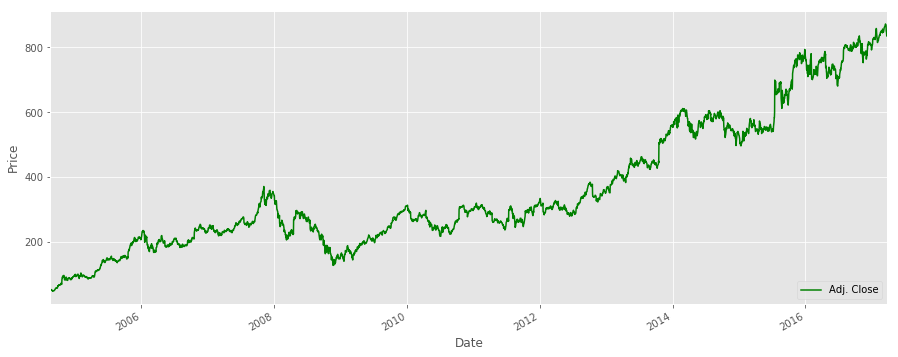

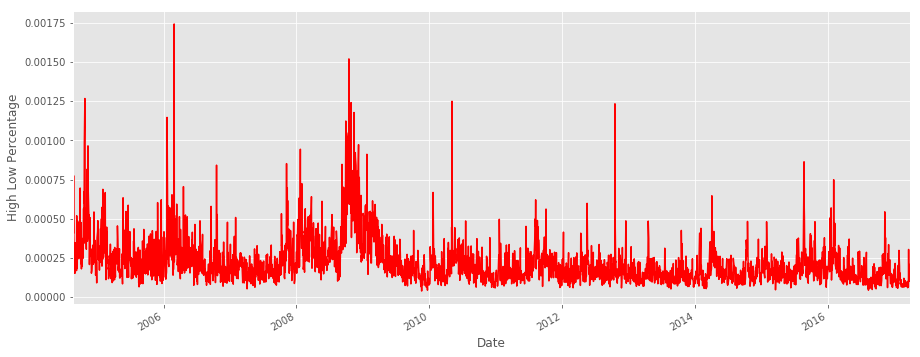

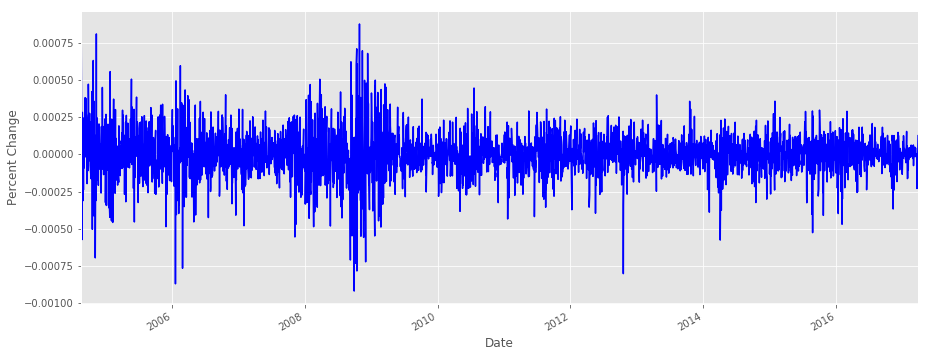

In [190]:
# Visualization

df['Adj. Close'].plot(figsize=(15,6), color="green")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

df['HL_PCT'].plot(figsize=(15,6), color="red")
plt.xlabel('Date')
plt.ylabel('High Low Percentage')
plt.show()

df['PCT_CHNG'].plot(figsize=(15,6), color="blue")
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.show()


## Machine Learning

### Creating Features and Label

In [191]:
# pick a forecast column
forecast_col = 'Adj. Close'

# Chosing 30 days as number of forecast days
forecast_out = int(30)
print('length =',len(df), "and forecast_out =", forecast_out)

length = 3173 and forecast_out = 30


In [192]:
# Creating label by shifting 'Adj. Close' according to 'forecast_out'
df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head(2))
print('\n')
# If we look at the tail, it consists of n(=forecast_out) rows with NAN in Label column 
print(df.tail(2))

            Adj. Close    HL_PCT  PCT_CHNG  Adj. Volume      label
Date                                                              
2004-08-19   50.322842  0.000844  0.000032   44659000.0  66.495265
2004-08-20   54.322689  0.000854  0.000723   22834300.0  67.739104


            Adj. Close    HL_PCT  PCT_CHNG  Adj. Volume  label
Date                                                          
2017-03-24      835.14  0.000180 -0.000081    2080936.0    NaN
2017-03-27      838.51  0.000207  0.000126    1922073.0    NaN


In [193]:
# Define features (X) by excluding the label column which we just created 
X = np.array(df.drop(['label'], 1))
# Using a feature in sklearn, preposessing to scale features
X = preprocessing.scale(X)
print(X[1,:])

[-1.51873027  4.29658969  4.73498142  1.73495807]


In [194]:
# X contains last 'n= forecast_out' rows for which we don't have label data
# Put those rows in different Matrix X_forecast_out by X_forecast_out = X[end-forecast_out:end]

X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]
print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))


Length of X_forecast_out: 30 & Length of X : 3143


In [195]:
# Similarly Define Label y for the data we have prediction for
# A good test is to make sure length of X and y are identical
y = np.array(df['label'])
y = y[:-forecast_out]
print('Length of y: ',len(y))

Length of y:  3143


### Creating Training and Test Sets

Using cross validation basically shuffles the data and according to our test_size criteria, splits the data into test and training data.

In [196]:
# Cross validation (split into test and train data)
# test_size = 0.2 ==> 20% data is test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  2514 629


### Using Linear Regression
Now time to use linear regression. I first Split the data into 80% of training data and 20% of test data. Used Linear regression to train and test data. Finally, I tested the accuracy of our model on the test data.

In [197]:
# Train
clf = LinearRegression()
clf.fit(X_train,y_train)
# Test
accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.97469687946


In [198]:
# Predict using our Model
forecast_prediction = clf.predict(X_forecast_out)
print(forecast_prediction)

[ 846.77765824  847.91972606  845.22013582  849.99170986  854.03470016
  857.04579418  858.979216    858.53564003  855.59422798  857.30445545
  852.70919094  863.95054971  857.77724182  856.95606759  855.05463666
  858.79589268  861.49151795  865.31415252  869.11320698  872.18038495
  873.54875643  875.9179302   877.79452922  879.84986158  875.53405708
  857.17235423  857.42685204  846.64424381  842.49199376  845.18269079]


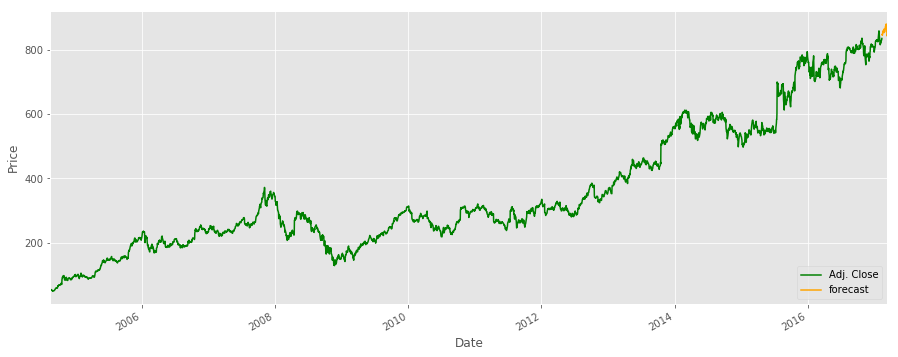

In [199]:
# Plotting data
df.dropna(inplace=True)
df['forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_prediction:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
df['Adj. Close'].plot(figsize=(15,6), color="green")
df['forecast'].plot(figsize=(15,6), color="orange")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

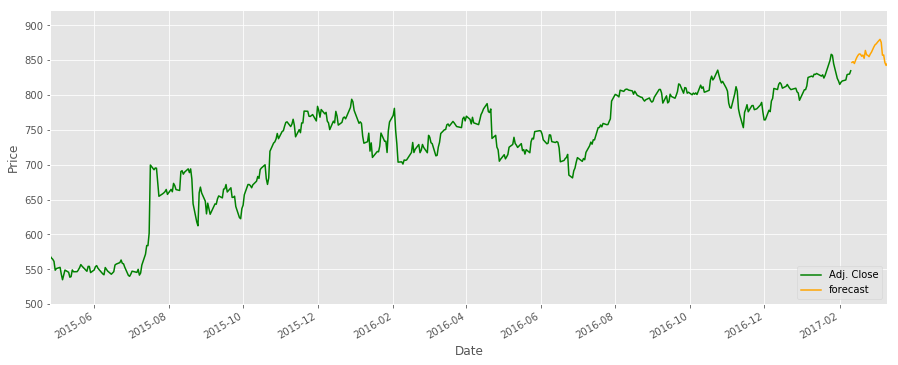

In [207]:
# Zoomed In to a year
df['Adj. Close'].plot(figsize=(15,6), color="green")
df['forecast'].plot(figsize=(15,6), color="orange")
plt.xlim(xmin=datetime.date(2015, 4, 26))
plt.ylim(ymin=500)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()